In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

# Transformer Encoder

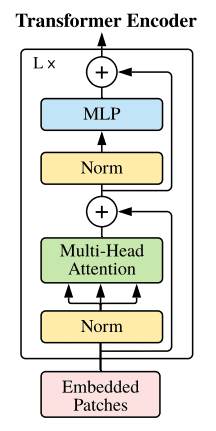
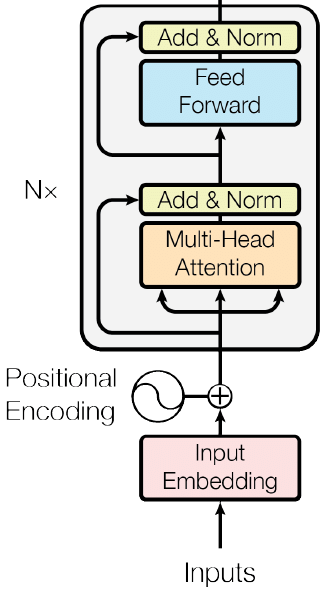

## Embedded Patches block

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size=224, in_channels=3, patch_size=16, hidden_dim=768):
    super(PatchEmbedding, self).__init__()
    """
    H, W: 224
    C: 3
    P: 16
    D: 768
    """
    self.img_size = img_size
    self.in_channels = in_channels
    self.patch_size = patch_size
    self.hidden_dim = hidden_dim
    #Number of patches
    self.num_patches = (self.img_size * self.img_size) // (self.patch_size * self.patch_size)

    #x_class
    self.class_embedding = nn.Parameter(torch.randn(1, 1, self.hidden_dim)) #(1, 1, D)

    #Linear projection (E)
    self.projection = nn.Linear(self.patch_size * self.patch_size * self.in_channels, self.hidden_dim) #(P^2 * C, D)

    #Pos_embedding (E_pos)
    self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.hidden_dim)) #(1, N+1, D)

  def forward(self, x):
    #Chia ảnh thành các patches
    B, C, H, W = x.shape
    x = x.unfold(2, self.patch_size, self.patch_size) #(B, C, Num_patches_H, P, W)
    x = x.unfold(3, self.patch_size, self.patch_size) #(B, C, Num_patches_H, Num_patches_W, P, P)
    x = x.permute(0, 2, 3, 1, 4, 5).contiguous() #(B, Num_patches_H, Num_patches_W, C, P, P)
    x = x.view(B, self.num_patches, -1) #(B, N, P*2 \times C)

    #Ánh xạ vào không gian embedding
    x = self.projection(x) #(B, N, D)

    #Expand để class token có cùng chiều với projection
    class_token = self.class_embedding.expand(B, -1, -1) #(B, 1, D)

    #Ghép class token vào đầu chuỗi patches
    x = torch.cat([class_token, x], dim=1) #(B, N+1, D)

    #Cộng với E_pos -> z_0
    x = x + self.pos_embedding #(B, N+1, D)

    return x #encoded_value

## Multi Head Attention block

In [ ]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, hidden_dim=768, heads=12):
    super(MultiHeadSelfAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.heads = heads
    self.head_dim = hidden_dim // heads

    #Khởi tạo trọng số cho query, key, value
    self.W_Q = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.W_K = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.W_V = nn.Linear(self.hidden_dim, self.hidden_dim)

    self.softmax = nn.Softmax(dim=-1)
    self.output = nn.Linear(self.hidden_dim, self.hidden_dim) #Kết hợp đầu ra của các heads

  def forward(self, x):
    #x: encoded_value có kích thước là (B, N+1, D)
    B, N, D = x.shape #Batch_size, Số tokens, hidden_dim #(B, N+1, D theo N ban đầu)

    #Tính query, key, value
    q = self.W_Q(x).view(B, N, self.heads, self.head_dim).transpose(1, 2)
    k = self.W_K(x).view(B, N, self.heads, self.head_dim).transpose(1, 2)
    v = self.W_V(x).view(B, N, self.heads, self.head_dim).transpose(1, 2)

    #Tính attention score
    unscaled_dot_product_similarities = torch.matmul(q, k.transpose(-1, -2)) #QK^T
    scaled_dot_product_similarities = unscaled_dot_product_similarities / (self.head_dim ** 0.5) #QK^T / sqrt(d_k)
    attention_weights = self.softmax(scaled_dot_product_similarities) #softmax(QK^T / sqrt(d_k))
    attention_score = torch.matmul(attention_weights, v) #softmax(QK^T / sqrt(d_k))V

    #Gộp các đầu SA lại với nhau
    output = attention_score.transpose(1, 2).contiguous().view(B, N, D)

    #Ánh xạ lại không gian embedding
    output = self.output(output)

    return output

## Transformer encoder

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, img_size=224, layers=12, patch_size=16, in_channels=3, hidden_dim=768, heads=12, mlp_size=3072):
    super(TransformerEncoder, self).__init__()
    self.hidden_dim = hidden_dim #D=768
    self.in_channels = in_channels #C=3
    self.heads = heads
    self.layers = layers
    self.mlp_size = mlp_size
    self.img_size = img_size
    self.patch_size = patch_size
    self.embedded_patches = PatchEmbedding(img_size=self.img_size, patch_size=self.patch_size, in_channels=self.in_channels, hidden_dim=self.hidden_dim)

    #Khởi tạo khối transformer
    self.transformer_blocks = nn.ModuleList([
        nn.ModuleList([
            nn.LayerNorm(self.hidden_dim),
            MultiHeadSelfAttention(hidden_dim=self.hidden_dim, heads=self.heads),
            nn.LayerNorm(self.hidden_dim),
            nn.Sequential(
                nn.Linear(self.hidden_dim, self.mlp_size),
                nn.GELU(),
                nn.Dropout(0.1),
                nn.Linear(self.mlp_size, self.hidden_dim),
                nn.Dropout(0.1)
            )
        ]) for _ in range(self.layers)
      ])

  def forward(self, x):
    x = self.embedded_patches(x)
    for norm1, msa, norm2, mlp in self.transformer_blocks:
      x = x + msa(norm1(x))
      x = x + mlp(norm2(x))
    return x

#ViT

In [ ]:
class MLPHead(nn.Module):
  def __init__(self, hidden_dim=768, num_classes=1000):
    super(MLPHead, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    self.norm = nn.LayerNorm(self.hidden_dim)
    self.fc = nn.Linear(self.hidden_dim, self.num_classes)

  def forward(self, x):
    #Lấy ra x_class từ đầu ra của encoder
    class_token = x[:, 0, :]
    class_token = self.norm(class_token)
    output = self.fc(class_token)

    return output

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, hidden_dim=768, layers=12, heads=12, mlp_size=3072, in_channels=3, num_classes=1000, img_size=224, patch_size=16):
    super(VisionTransformer, self).__init__()
    self.encoder = TransformerEncoder(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=in_channels,
        hidden_dim=hidden_dim,
        layers=layers,
        heads=heads,
        mlp_size=mlp_size
    )
    self.mlp_head = MLPHead(hidden_dim=hidden_dim, num_classes=num_classes)

  def forward(self, x):
    x = self.encoder(x)
    output = self.mlp_head(x)

    return output

In [ ]:
# Tạo instance của VisionTransformer
model = VisionTransformer()

# Tạo batch ảnh giả lập
dummy_input = torch.randn(1, 3, 224, 224)  # (B, C, H, W)

# Chạy forward pass
output = model(dummy_input)
print(output.shape)  # Kết quả mong đợi: torch.Size([1, 1000])

torch.Size([1, 1000])


# Load dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

batch_size = 64
trainset = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


# Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(
    in_channels=1,
    img_size=32,
    patch_size=4,
    hidden_dim=128,
    layers=8,
    heads=8,
    mlp_size=256,
    num_classes=10
    ).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-05)

Epoch [1/100], Loss: 1.9899, LR: 0.000010
Epoch [2/100], Loss: 0.6840, LR: 0.000010
Epoch [3/100], Loss: 0.4186, LR: 0.000010
Epoch [4/100], Loss: 0.3218, LR: 0.000010
Epoch [5/100], Loss: 0.2692, LR: 0.000010
Epoch [6/100], Loss: 0.2340, LR: 0.000010
Epoch [7/100], Loss: 0.2075, LR: 0.000010
Epoch [8/100], Loss: 0.1867, LR: 0.000010
Epoch [9/100], Loss: 0.1701, LR: 0.000010
Epoch [10/100], Loss: 0.1574, LR: 0.000010
Epoch [11/100], Loss: 0.1455, LR: 0.000010
Epoch [12/100], Loss: 0.1355, LR: 0.000010
Epoch [13/100], Loss: 0.1276, LR: 0.000010
Epoch [14/100], Loss: 0.1199, LR: 0.000010
Epoch [15/100], Loss: 0.1129, LR: 0.000010
Epoch [16/100], Loss: 0.1075, LR: 0.000010
Epoch [17/100], Loss: 0.1021, LR: 0.000010
Epoch [18/100], Loss: 0.0975, LR: 0.000010
Epoch [19/100], Loss: 0.0920, LR: 0.000010
Epoch [20/100], Loss: 0.0884, LR: 0.000010
Epoch [21/100], Loss: 0.0865, LR: 0.000010
Epoch [22/100], Loss: 0.0812, LR: 0.000010
Epoch [23/100], Loss: 0.0781, LR: 0.000010
Epoch [24/100], Loss

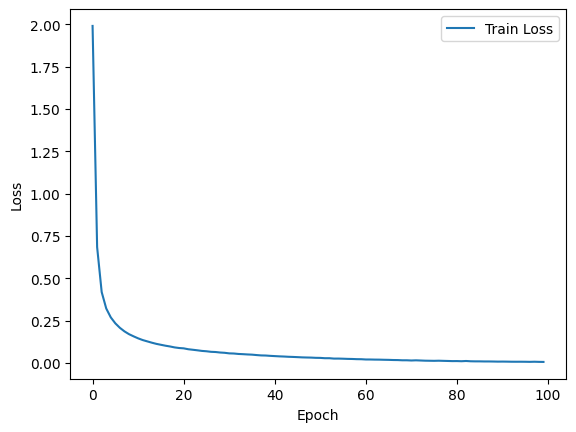

In [ ]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on MNIST test set: {accuracy:.2f}%")

Accuracy on MNIST test set: 98.39%


In [ ]:
image, label = testset[0]
image = image.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

tensor([7], device='cuda:0')


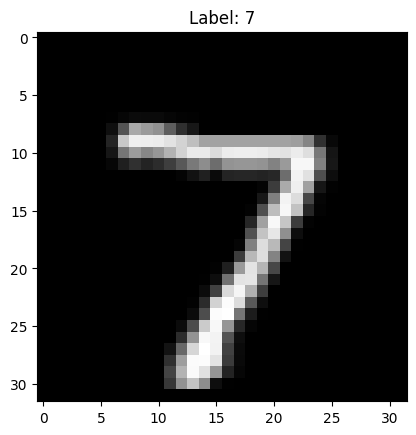

In [ ]:
print(predicted)

image = image.squeeze().to('cpu')

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [ ]:
# Lưu mô hình
torch.save(model.state_dict(), "ViT_mnist.pth")